In [1]:
pip install -q usaddress

Note: you may need to restart the kernel to use updated packages.


---

In [2]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import usaddress
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
import nltk
#nltk.download()
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

Goals: To investigate current market conditions—and develop the best strategy for a new robot coffee.

##### Table of contents: 

* [Download the data and prepare it for analysis](#st1)
* [Step 2. Data analysis](#st2)
* [Conclusion](#st3)
* [Presentation](#st4)

# 1. Preparing the Data <a class="anchor" id="st1"></a>

In [3]:
try:
    data = pd.read_csv('~/Downloads/rest_data_us.csv')
except:
    data = pd.read_csv('/datasets/rest_data_us.csv')

In [4]:
data.head(3)

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20


In [5]:
def cleaning_final(raw):
    if raw.startswith('OLVERA'):
        clean_adress='OLVERA,Los Angeles,USA'
    elif raw.startswith('1033 1/2 LOS ANGELES'):
        clean_adress='1033 1/2 LOS ANGELES ST,Los Angeles,USA'
    else:
        raw_address=usaddress.parse(raw)
        dict_address={}
        for i in raw_address:
            dict_address.update({i[1]:i[0]})
        clean_adress=dict_address['AddressNumber']+" "+str(dict_address['StreetName'])+str(', Los Angeles,USA')
    return clean_adress

We have build a functon for finding a clean adress including city and country.

In [6]:
data['clean_street']=data.address.apply(cleaning_final)
data.sample(10)

,id,object_name,address,chain,object_type,number,clean_street
563,12349,TAKE 5,404 S FIGUEROA ST LVL E,False,Restaurant,34,"404 FIGUEROA, Los Angeles,USA"
5524,17310,SANDWICH SHOP CORP.,531 W 6TH ST,False,Restaurant,17,"531 6TH, Los Angeles,USA"
9405,21191,CAT CAFE LOUNGE,1736 S SEPULVEDA BLVD,False,Restaurant,23,"1736 SEPULVEDA, Los Angeles,USA"
7416,19202,COFFEE BEAN & TEA LEAF #348,9829 VENICE BLVD,True,Cafe,2,"9829 VENICE, Los Angeles,USA"
794,12580,COLOMBO'S ITALIAN STEAKHOUSE,1833 COLORADO BLVD,False,Restaurant,92,"1833 COLORADO, Los Angeles,USA"
6881,18667,ELA SERVICE CENTER,133 N SUNOL DR,False,Restaurant,36,"133 SUNOL, Los Angeles,USA"
1057,12843,SUBWAY,610 S RAMPART BLVD,True,Fast Food,22,"610 RAMPART, Los Angeles,USA"
8946,20732,ROCCO'S TAVERN,1000 GAYLEY AVE,True,Restaurant,134,"1000 GAYLEY, Los Angeles,USA"
8718,20504,TAPAS AND WINE BAR C,428 E 2ND ST,False,Bar,33,"428 2ND, Los Angeles,USA"
8069,19855,CALIFORNIA SALSA,201 N LOS ANGELES ST #104,False,Restaurant,45,"201 ANGELES, Los Angeles,USA"


In [7]:
def cleaning_tag(raw):
    try:
        if raw.startswith('OLVERA'):
            clean_adress='OLVERA,Los Angeles,USA'
        elif raw.startswith('1033 1/2 LOS ANGELES'):
            clean_adress='1033 1/2 LOS ANGELES ST,Los Angeles,USA'
        elif raw.startswith('3425 E 1ST ST SO. 3RDFL'):
            clean_adress='3425 E 1ST ST SO. 3RDFL'
        else:
            clean_adress=usaddress.tag(raw)[0]['StreetName']
    except:
        clean_adress='no street'
    return clean_adress

function for having the street tag left.

In [8]:
data['clean_street_tag']=data.address.apply(cleaning_tag)

we have created clean street name out of address column.

In [9]:
data.head()

,id,object_name,address,chain,object_type,number,clean_street,clean_street_tag
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26,"3708 ROCK, Los Angeles,USA",EAGLE ROCK
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9,"100 WORLD, Los Angeles,USA",WORLD
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20,"6801 HOLLYWOOD, Los Angeles,USA",HOLLYWOOD
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22,"1814 SUNSET, Los Angeles,USA",SUNSET
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20,"2100 PARK, Los Angeles,USA",ECHO PARK


In [10]:
data.duplicated().sum()

0

In [11]:
data.isnull().sum()

id                  0
object_name         0
address             0
chain               3
object_type         0
number              0
clean_street        0
clean_street_tag    0
dtype: int64

In [12]:
data[data['chain'].isnull()]

,id,object_name,address,chain,object_type,number,clean_street,clean_street_tag
7408,19194,TAQUERIA LOS 3 CARNALES,5000 E WHITTIER BLVD,NaN,Restaurant,14,"5000 WHITTIER, Los Angeles,USA",WHITTIER
7523,19309,JAMMIN JIMMY'S PIZZA,1641 FIRESTONE BLVD,NaN,Pizza,1,"1641 FIRESTONE, Los Angeles,USA",FIRESTONE
8648,20434,THE LEXINGTON THEATER,129 E 3RD ST,NaN,Restaurant,35,"129 3RD, Los Angeles,USA",3RD


we have found three not-attributed places. Let's check weather they have connected to any chain.

In [13]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
data['lemmatized'] = data['object_name'].apply(lemmatize_text)

we have created a new column for having each name lemmatized.

In [14]:
for index, row in data.iterrows():
    if 'CARNALES' in row[8]:
        print(row)

id                                          18205
object_name                    TACOS LOS CARNALES
address                        4370 S CENTRAL AVE
chain                                       False
object_type                             Fast Food
number                                         47
clean_street        4370 CENTRAL, Los Angeles,USA
clean_street_tag                          CENTRAL
lemmatized                 [TACOS, LOS, CARNALES]
Name: 6419, dtype: object
id                                           18410
object_name                   TACOS LOS 3 CARNALES
address                         5000 WHITTIER BLVD
chain                                        False
object_type                              Fast Food
number                                           6
clean_street        5000 WHITTIER, Los Angeles,USA
clean_street_tag                          WHITTIER
lemmatized               [TACOS, LOS, 3, CARNALES]
Name: 6624, dtype: object
id                                     

Even though every place seems to have positioned in the data as the non-chained place, they have slightly different names and seem to have similar addresses - 5000 WHITTIER BLVD- therefore, there might be a mistake in the data.

In [15]:
data[data['address']== '5000 WHITTIER BLVD']

,id,object_name,address,chain,object_type,number,clean_street,clean_street_tag,lemmatized
6624,18410,TACOS LOS 3 CARNALES,5000 WHITTIER BLVD,False,Fast Food,6,"5000 WHITTIER, Los Angeles,USA",WHITTIER,"[TACOS, LOS, 3, CARNALES]"
9616,21402,TACOS LOS 4 CARNALES,5000 WHITTIER BLVD,False,Fast Food,9,"5000 WHITTIER, Los Angeles,USA",WHITTIER,"[TACOS, LOS, 4, CARNALES]"


In [16]:
data.columns[3]

'chain'

In [17]:
for index, row in data.iterrows():
    if 'CARNALES' in row[8]:
        row[3] = True
data = data[~(data['address'] == '5000 E WHITTIER BLVD')]
data = data[~(data['object_name'] == 'TACOS LOS 4 CARNALES')]

In [18]:
for index, row in data.iterrows():
    if 'LEXINGTON' in row[8]:
        print(row)
        


id                                      20434
object_name             THE LEXINGTON THEATER
address                          129 E 3RD ST
chain                                     NaN
object_type                        Restaurant
number                                     35
clean_street         129 3RD, Los Angeles,USA
clean_street_tag                          3RD
lemmatized          [THE, LEXINGTON, THEATER]
Name: 8648, dtype: object


In [19]:
for index, row in data.iterrows():
    if 'JAMMIN' in row[8]:
        print(row)


id                                          18576
object_name                        WI JAMMIN CAFE
address                       1359 S REDONDO BLVD
chain                                       False
object_type                            Restaurant
number                                         28
clean_street        1359 REDONDO, Los Angeles,USA
clean_street_tag                          REDONDO
lemmatized                     [WI, JAMMIN, CAFE]
Name: 6790, dtype: object
id                                            19309
object_name                    JAMMIN JIMMY'S PIZZA
address                         1641 FIRESTONE BLVD
chain                                           NaN
object_type                                   Pizza
number                                            1
clean_street        1641 FIRESTONE, Los Angeles,USA
clean_street_tag                          FIRESTONE
lemmatized                 [JAMMIN, JIMMY'S, PIZZA]
Name: 7523, dtype: object


In [20]:
data['chain'].replace({'NaN':"False"}, inplace = True)
data['chain'].value_counts()

False    5971
True     3676
Name: chain, dtype: int64

##### Conclusion part 1

We have downloaded the data, created clean street tags and clean address columns, and removed the chain column's NaN values. The data seem to be ready for analysis.

# Part 2. <a class="anchor" id="st2"></a>

- Investigate the prorportions of the various types of establishments. Plot a graph.

In [21]:
establishments = data.groupby('object_type')['object_name'].count().reset_index()
establishments.sort_values(by = 'object_name', inplace=True)

In [22]:
establishments

,object_type,object_name
0,Bakery,283
1,Bar,292
4,Pizza,320
2,Cafe,435
3,Fast Food,1065
5,Restaurant,7254


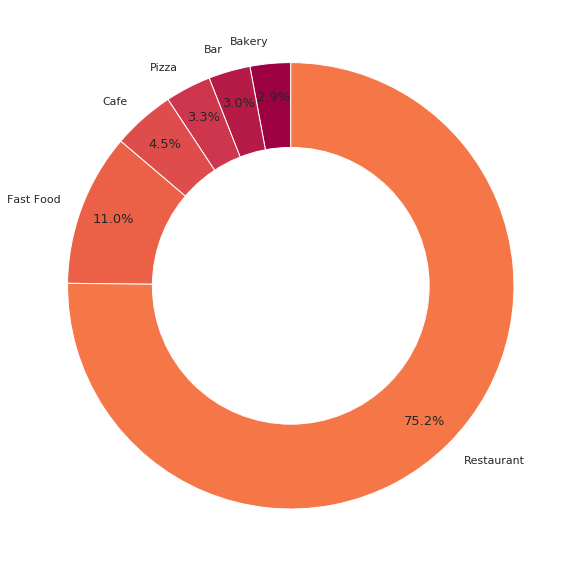

In [23]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 13.0
cmap = plt.get_cmap('Spectral')
sizes = establishments['object_name']
labels = establishments['object_type']
colors = [cmap(i) for i in np.linspace(0, 1, 24)]
the_grid = GridSpec(4, 3)
#plt.subplot(the_grid[0, 1], aspect=1, title="Establishments by type")
plt.figure(figsize = (10,11))
plt.pie(x=sizes, autopct="%.1f%%", labels=labels, colors= colors, pctdistance=0.85, rotatelabels =False, startangle=90)
centre_circle = plt.Circle((0,0),0.62,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


plt.show()

As we can see, coffee shops make up only 4.5% of the establishments in LA. The most popular types of establishments are restaurants.

- Investigate proportions of chain and non-chain establishments. Plot a graph.

In [24]:
establishments = data.groupby(['chain', 'object_type'])['object_name'].count().reset_index()
establishments 

,chain,object_type,object_name
0,False,Bar,215
1,False,Cafe,169
2,False,Fast Food,460
3,False,Pizza,166
4,False,Restaurant,4961
5,True,Bakery,283
6,True,Bar,77
7,True,Cafe,266
8,True,Fast Food,605
9,True,Pizza,153


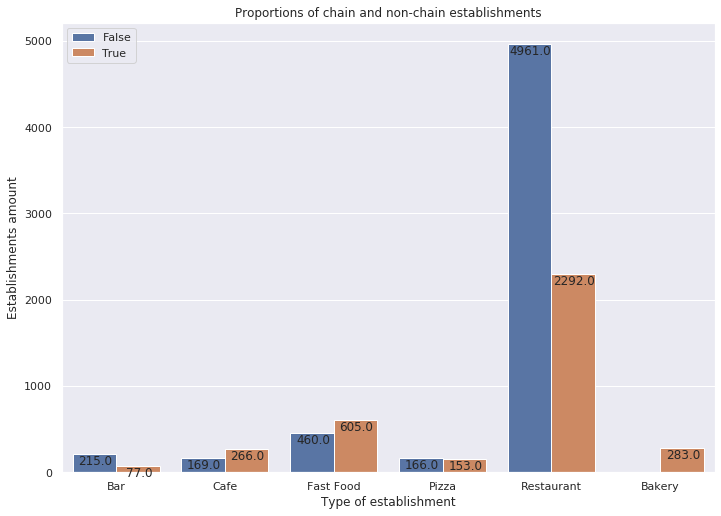

In [25]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
labels = establishments['object_name']
splot=sns.barplot(data = establishments, x = 'object_type', y = 'object_name', hue = 'chain', ax=ax)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (1, -7), 
                   textcoords = 'offset points')
plt.title('Proportions of chain and non-chain establishments')
plt.ylabel('Establishments amount')
plt.xlabel('Type of establishment')
plt.legend()
plt.show()

- Which type of establishment is typycally a chain?

According to the previous graphs there's no establishments of the bakery type, which are not chains.

- What characterizes chains: many establishments with a small number of seats or a few establishments with a lot of seats? 

In [26]:
chains = data[data['chain'] == True] 
nchains = data[data['chain'] == False] 


In [27]:
frequencies = Counter(word for sentence in chains['lemmatized'] for word in sentence)
for word, frequency in frequencies.most_common(70):
    print(word, frequency)

RESTAURANT 643
BAKERY 277
COFFEE 216
& 204
THE 184
FOOD 162
EL 153
PIZZA 152
SUBWAY 151
CAFE 149
STARBUCKS 127
LA 117
DELI 96
EXPRESS 89
# 85
MCDONALD'S 82
TEA 82
AND 81
GRILL 75
MEXICAN 70
LEAF 68
BURGER 66
KING 66
BEAN 66
JUICE 62
DONUTS 60
CHINESE 59
IN 57
CHICKEN 56
BAR 56
BOX 55
JACK 53
TACO 52
THAI 49
SUSHI 49
HOUSE 47
KITCHEN 47
POLLO 46
SEAFOOD 43
LITTLE 42
FRIED 41
LOCO 39
PANDA 37
LOS 37
RESTAURANTE 37
TACOS 34
MARKET 34
BELL 33
DONUT 32
YUM 32
HUT 31
DOMINO'S 30
YOSHINOYA 29
BOBA 28
CHINA 28
HONG 26
TRIMANA 26
CARL'S 25
KONG 25
FAST 25
JR 24
FOODS 24
JOHN'S 24
FRESH 23
LOUISIANA 23
INC 23
Y 23
- 22
ROCK 22
CHIPOTLE 22


In [28]:
for index, row in chains.iterrows():
    if 'STARBUCKS' in row[8]:
        row[2]='STARBUCKS'
    if 'SUBWAY' in row[8]:
        row[2] = 'SUBWAY'
    if  'MCDONALD\S' in row[8]:
        row[2] = 'MCDONALD\'S'
    if 'DOMINO\'S' in row[8]:
        row[2] = 'Domino\'s pizza'

Ensuring the biggest chains are fully represented.

In [29]:
chains_names = chains.object_name.value_counts().reset_index()
one_plc_chain_names =  chains_names[chains_names['object_name']==1]
one_plc_chain = chains[chains['object_name'].isin(one_plc_chain_names['index'])]
chains = chains[~chains['object_name'].isin(one_plc_chain['object_name'])]
chains= chains.reset_index()

Creating dataframes for saving none chained and chained places separately.

In [30]:
chainss = chains.groupby('object_name').agg({'number':'mean', 'address':'count'}).reset_index()
chainss.columns = ['object_name','number_of_seats', 'places_in_chain']

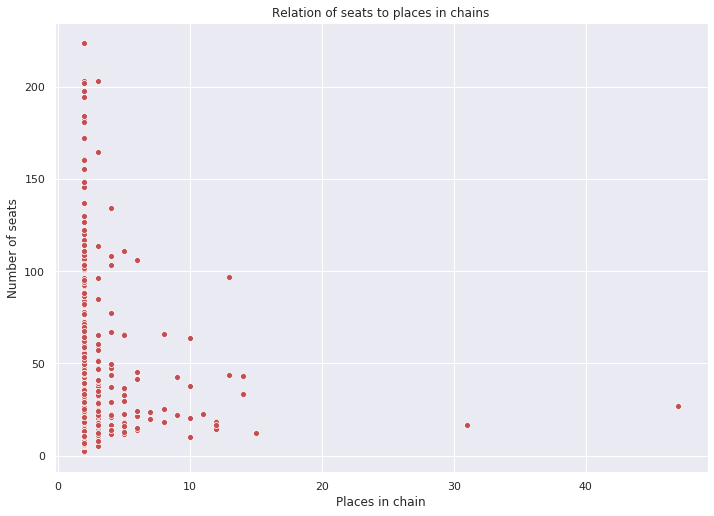

In [31]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
#sns.color_palette("vlag", as_cmap=True)
sns.scatterplot(data=chainss, x= 'places_in_chain', y = 'number_of_seats', ax = ax, palette = 'bright', color='r')
plt.title('Relation of seats to places in chains')
plt.ylabel('Number of seats')
plt.xlabel('Places in chain')
plt.show()

As we can see, most of the places in chains are few establishments with many seats.

- Determine the average number of seats for each type of restaurant. On average, which type of restaurant has the greatest number of seats?

In [32]:
number = data.groupby(['chain'])['number'].mean().reset_index()

In [33]:
number.number = round(number.number, 2)
number

,chain,number
0,False,46.18
1,True,39.69


We can see that the average amount of seats for the chained places is lower than for the private ones. Let's see how it corresponds with the type of place.

In [34]:
seats = data.groupby(['chain', 'object_type']).agg({'number':'mean'}).reset_index()
seats.number = round(seats.number, 2)
seats.sort_values(by='number', inplace = True)
seats

,chain,object_type,number
5,True,Bakery,21.77
1,False,Cafe,23.56
2,False,Fast Food,23.67
9,True,Pizza,25.53
7,True,Cafe,25.92
3,False,Pizza,31.33
8,True,Fast Food,38.09
6,True,Bar,40.26
10,True,Restaurant,44.86
0,False,Bar,46.38


In [35]:
seats.chain = seats.chain.astype('str')
seats.chain = seats.chain.replace(regex = 'True', value='chained')
seats.chain = seats.chain.replace(regex ='False', value = 'non-chained')

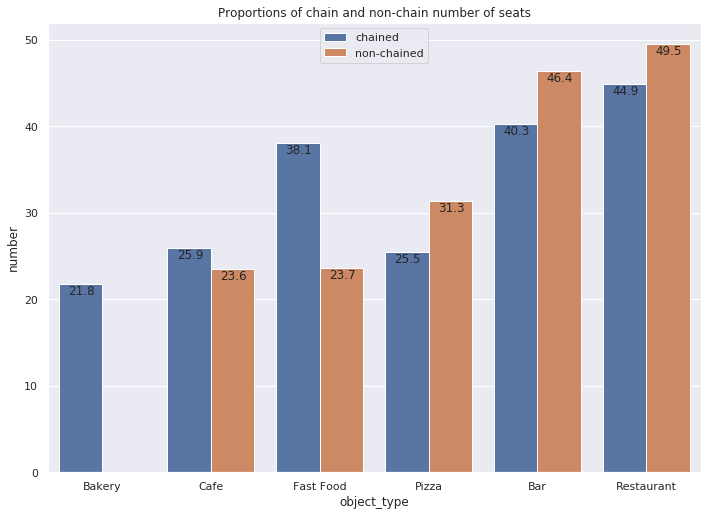

In [36]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
splot = sns.barplot(data = seats, x = 'object_type', y = 'number', hue = 'chain', dodge=True, 
                     ax=ax)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (1, -7), 
                   textcoords = 'offset points')
g=plt.title('Proportions of chain and non-chain number of seats')
plt.legend()
plt.show()


We have calculated the average number of seats for chained and non-chained establishments. As we can see, the trend differs among different types of establishments. Non-chained bars, pizzas, and restaurants have more seats than chained places of the same type. Non-chained cafes, fast-food, and bakeries have, on average fewer seats than chained establishments.  I suppose that the general trend is the economy. The chained places represent the whole system and can afford themselves more expenses on having fewer customers in places like restaurants and bars, while places like fast food and bakeries don't have to have seated places.

- Plot the graph on the top 10 streets by number of restaurants

In [37]:
rests = data[data['object_type']== 'Restaurant' ]
street = rests.groupby('clean_street_tag')['object_name'].count().sort_values(ascending=False).reset_index()


In [38]:
street.columns = ['street_name', 'number_of_restaurants']

In [39]:
streets = street.head(10)
streets.number_of_restaurants
streets = pd.DataFrame(streets)
streets

,street_name,number_of_restaurants
0,WILSHIRE,319
1,SUNSET,297
2,WESTERN,292
3,PICO,283
4,OLYMPIC,257
5,FIGUEROA,234
6,VERMONT,218
7,3RD,208
8,SANTA MONICA,204
9,HOLLYWOOD,197


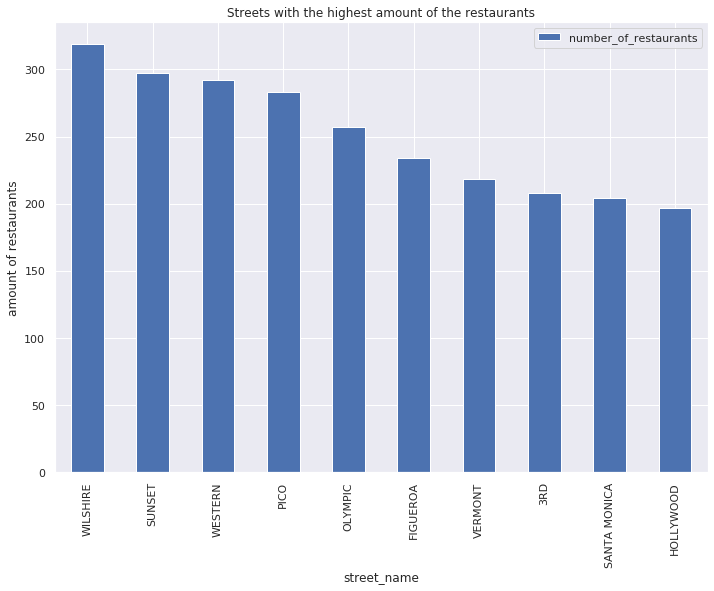

In [40]:
# plt.figure(figsize = (11.7, 8.27))
streets.plot.bar(x='street_name', y = 'number_of_restaurants', figsize = (11.7, 8.27))

plt.title('Streets with the highest amount of the restaurants')
plt.ylabel('amount of restaurants')
plt.show()

While there are streets with more than 200 hundred restaurants at the city center, there are 201 streets with only one restaurant.


- Find the number of streets that only have one restaurant.

In [41]:
street.head(1)

,street_name,number_of_restaurants
0,WILSHIRE,319


In [42]:
one_rest_street= street[street['number_of_restaurants']==1].reset_index()

In [43]:
len(one_rest_street.number_of_restaurants)

201

- For streets with a lot of restaurants,look at the distribution of the number of seats.What trends can you see?

In [53]:
street

,street_name,number_of_restaurants
0,WILSHIRE,319
1,SUNSET,297
2,WESTERN,292
3,PICO,283
4,OLYMPIC,257
...,...,...
456,JUDGE JOHN AISO,1
457,JARVIS,1
458,JAPANESE VILLAGE PLZ,1
459,JAPANESE VILLAGE PLAZA,1


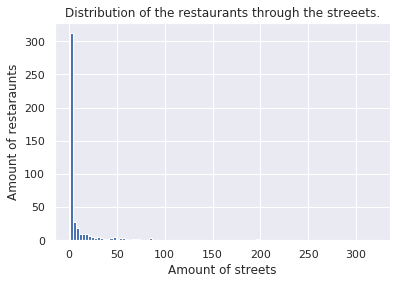

In [54]:
street.number_of_restaurants.hist(bins=100)
plt.title('Distribution of the restaurants through the streeets.')
plt.ylabel('Amount of restaraunts')
plt.xlabel('Amount of streets')
plt.show()

We can see that very few streets have more than 300 restaurants in them. Most of the streets have less than ten restaurants.

In [45]:
streets = data[data['clean_street_tag'].isin(streets['street_name'])].reset_index()

In [46]:
streets_s = streets.groupby('clean_street_tag').agg({'number':'mean', 'address':'count'}).reset_index()
streets_s

,clean_street_tag,number,address
0,3RD,40.532319,263
1,FIGUEROA,45.050898,334
2,HOLLYWOOD,57.047431,253
3,OLYMPIC,49.339806,309
4,PICO,40.632432,370
5,SANTA MONICA,35.045455,264
6,SUNSET,47.997525,404
7,VERMONT,45.371528,288
8,WESTERN,41.344173,369
9,WILSHIRE,52.655779,398


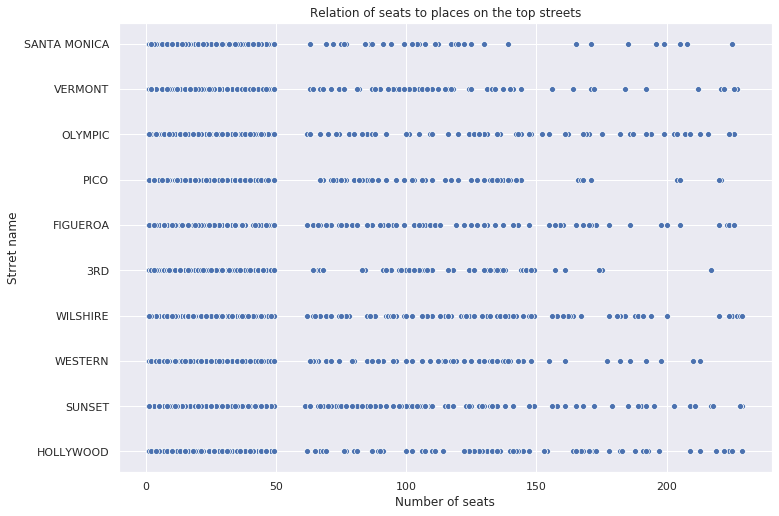

In [47]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.scatterplot(data=streets, x= 'number', y = 'clean_street_tag', ax = ax)
plt.xlabel('Number of seats')
plt.ylabel('Strret name')
plt.title('Relation of seats to places on the top streets')
plt.show()

As we can see, each street's main trend is having up to 50 seats for most places. As well as the trend of having from 50 to 150 seats, there we can see only slight changes, but only four streets have more than 150 seats at the places regularly.


# Conclusions: <a class="anchor" id="st3"></a>


- There are much more chained  than non-chained coffee places in the city, which should determine our choice of place and orientation on becoming a chain ourselves.
- It will be better to launch the cafe at one of the top ten streets with the lowest amount of places, to remain attainable by the customers and at the same time not be overrun by competitors.
- The city provides a lot of opportunities to the growth, there are 203 streets with only one establishment, where robot coffee can open it’s second branch.
- The chained establishments represented with the big amount of places and relatively small (36 at the average) amount of seats, while non-chained places usually have higher (46 at the average) amount of places. At the beginning it is better to use the non-chained model of capacity which can be changed with the growth of the robot cafe.


# Presentation link <a class="anchor" id="st4"></a>

Presentation: <https://www.dropbox.com/s/5fofnpxnpx6yyr5/Robot_cafe.pdf?dl=0> 